<a href="https://colab.research.google.com/github/aimanismail21/Project-Treehouse/blob/master/A2_Aiman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
#skip
! pip install fastai

In [2]:
pip install fastprogress

In [3]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 194kB 8.6MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 


Load dataset

In [4]:
import fastai
from torchvision.models import *  
from fastai.vision.all import *
from fastai.vision import *
from fastai.callback.hook import *
import numpy as np
from matplotlib import pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar

In [5]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()
(path/'images/').ls()
(path/'labels').ls()

(#100) [Path('/root/.fastai/data/camvid_tiny/labels/0016E5_07979_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f00810_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0016E5_07290_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0016E5_08101_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0001TP_008580_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0006R0_f02550_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f00090_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0016E5_08550_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f01890_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f01260_P.png')...]

In [6]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes # These are our features or categories of masks when segmenting.

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

The images folder contains the images, and the corresponding segmentation masks of labels are in the labels folder. The codes file contains the corresponding integer to class (the masks have an int value for each pixel).

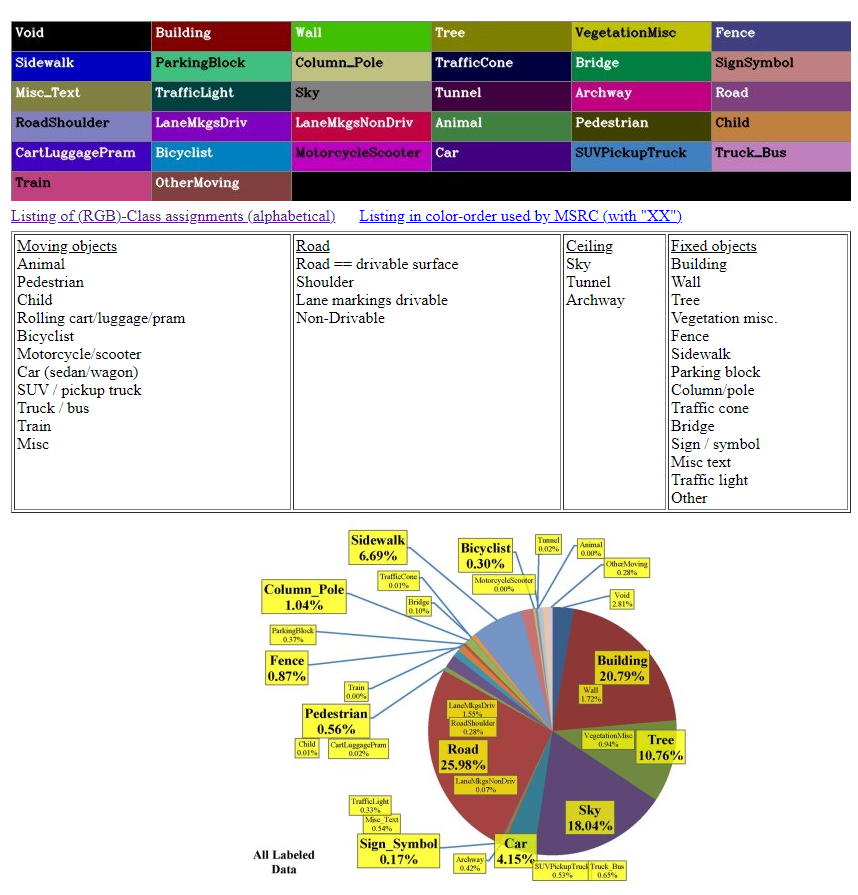

In [7]:
fnames = get_image_files(path/"images")
fnames[0]
image_fn = fnames[0]

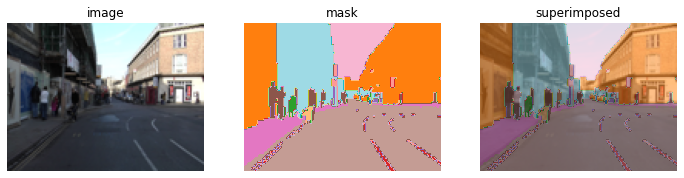

In [8]:
fns = get_image_files(path/'images')
cam_fn = fns[0]
mask_fn = path/'labels'/f'{cam_fn.stem}_P{cam_fn.suffix}'
cam_img = PILImage.create(cam_fn)
test_eq(cam_img.size, (128,96))
tmask = Transform(PILMask.create)
mask = tmask(mask_fn)
test_eq(type(mask), PILMask)
test_eq(mask.size, (128,96))
_,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=1, vmax=30, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);

In [9]:
(path/"labels").ls()[0]

Path('/root/.fastai/data/camvid_tiny/labels/0016E5_07979_P.png')

In [10]:
def label_func(fn): 
  return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [11]:
dls = SegmentationDataLoaders.from_label_func(
    path, # where to get files
    bs=8, # batch size
    fnames=fnames, # file_names
    label_func=label_func, # extract the file name
    codes=codes, # features / categories in the masks
    valid_pct=0.2, # 80 / 20 split
)

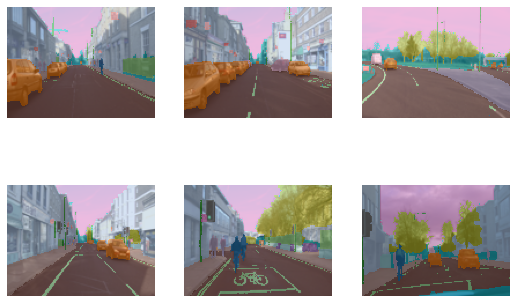

In [12]:
dls.show_batch(max_n=6)

A traditional CNN won't work for segmentation, we have to use a special kind of model called a UNet, so we use unet_learner to define our Learner:


**Parameters used in Training**


In [13]:
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [14]:
learn = unet_learner(dls,
                     resnet50,
                     pretrained=True,
                     metrics=[IoU]
                     )

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=3.630780702224001e-05)

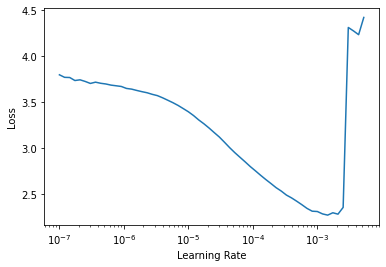

In [15]:
learn.lr_find()

First introduced by Leslie N. Smith in Cyclical Learning Rates for Training Neural Networks, the LR Finder trains the model with exponentially growing learning rates from start_lr to end_lr for num_it and stops in case of divergence (unless stop_div=False) then plots the losses vs the learning rates with a log scale.

A good value for the learning rates is then either:

one tenth of the minimum before the divergence
when the slope is the steepest

We will use the fine_tune method to specialize our base model for the specific task of segmentation for the masks we've provided.

This is a form of transfer learning since we're using a base model UNet that uses the Resnet34 model as its backbone. In other words, these models have been trained up to recognize a variety of things so we don't have to start from the beginning.

In [17]:
#Utilize min. lr from learn.lr_find() : 0.1 * lr_min = 0.1 * 0.00014454397605732084 = 0.000014
learn.fine_tune(epochs=50, base_lr=0.000014)



epoch,train_loss,valid_loss,IoU,time
0,1.566700,1.557231,0.045920,00:08


epoch,train_loss,valid_loss,IoU,time
0,1.338685,1.440565,0.050476,00:08
1,1.299778,1.360327,0.056726,00:08
2,1.265911,1.319479,0.059823,00:08
3,1.231284,1.284319,0.063320,00:08
4,1.191744,1.206281,0.068144,00:08
5,1.151469,1.153878,0.072363,00:08
6,1.113215,1.111513,0.076004,00:08
7,1.073968,1.077721,0.077973,00:08
8,1.031517,1.072722,0.080489,00:08
9,0.988550,1.005192,0.083782,00:08


By default, metrics are computed on the validation set only, 

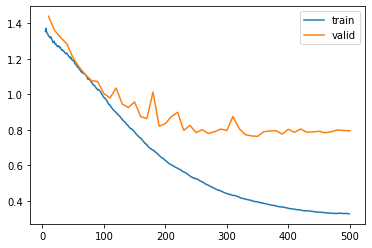

In [18]:
learn.recorder.plot_loss()

The tuning parameters suggest a training epoch length of 5


And as before, we can get some idea of the predicted results with show_results

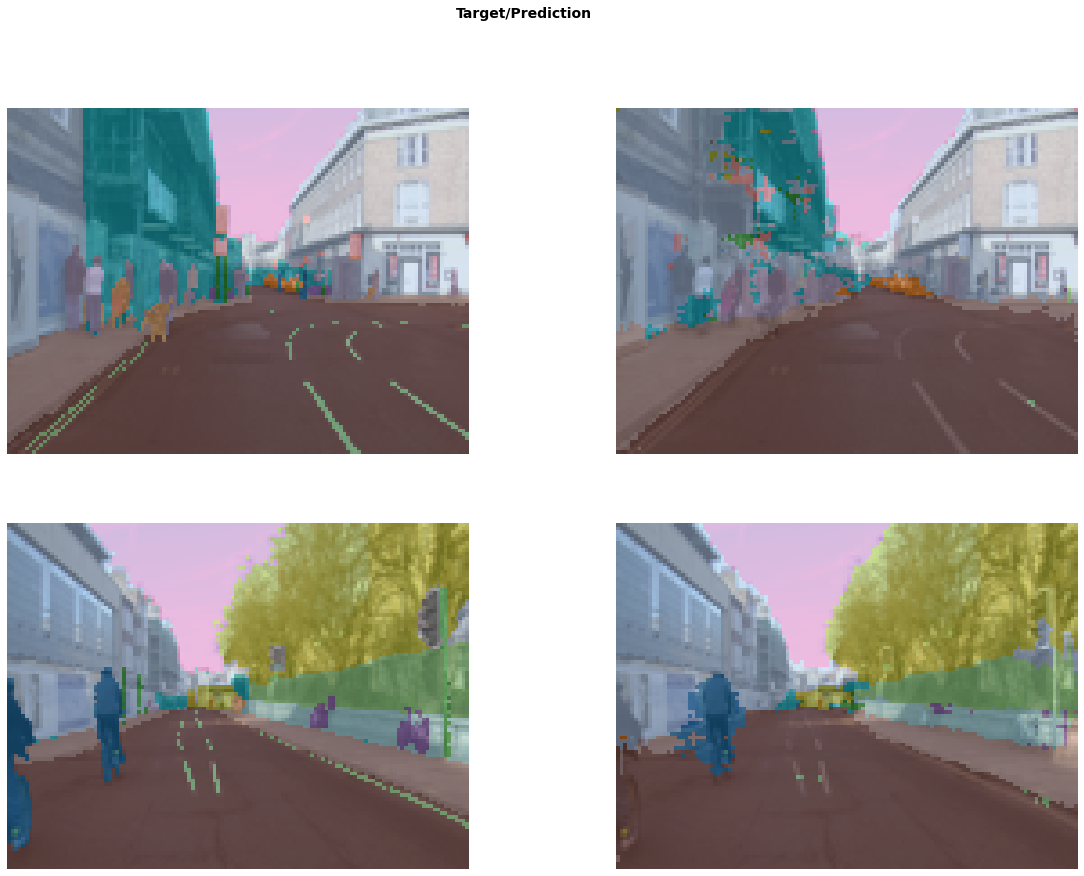

In [25]:
learn.show_results(max_n=4, figsize=(20,14))


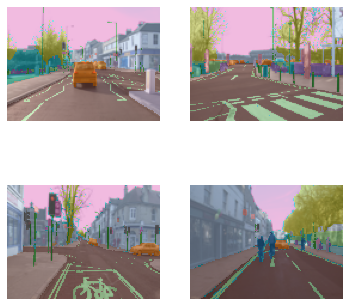

In [28]:
dls.show_batch(max_n=4)